In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
import numpy.matlib as matlib
import glob
import re
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import sys
import pickle
sess = tf.InteractiveSession()

In [2]:
def downsampleByTwo(img):
        tmp = np.array(img)
        # if the number of rows is odd, pad with a row of zeros
        if (tmp.shape[0] & 0x01):
            tmp = np.vstack([tmp, np.zeros((1, tmp.shape[1]))])

        if (tmp.shape[1] & 0x01):
            tmp = np.hstack([tmp, np.zeros((tmp.shape[0], 1))])

        ret = np.zeros(np.array(tmp.shape) / 2)

        for i in range(tmp.shape[0]):
            for j in range(tmp.shape[1]):
                ret[i/2,j/2] = .25 * tmp[i,j]

        return ret

def preprocessImage(img):
#     edges = ndimage.filters.sobel(img)
#     opening = ndimage.morphology.binary_opening(edges, structure=np.ones((2,2)))
    blurred = ndimage.gaussian_filter(img, 3)
#     edgesX = ndimage.sobel(blurred, axis=0)
#     edgesY = ndimage.sobel(blurred, axis=1)
#     edges = np.sqrt(edgesX ** 2 + edgesY ** 2)
    ds = downsampleByTwo(blurred)
    ds = downsampleByTwo(ds)
    ds = downsampleByTwo(ds)
    return ds

def readInFile(fName, preprocess=True):
    data = pd.read_csv(fName, index_col=0, dtype='object')

    ret = []
    
    isTestSet = False
    if 'species' in data:
        isTestSet = True

    marginCols = ['margin{0}'.format(i) for i in range(1, 65)]
    textureCols = ['texture{0}'.format(i) for i in range(1, 65)]
    shapeCols = ['shape{0}'.format(i) for i in range(1, 65)]

    labelMap = None
    if isTestSet:
        ## Generate one hot encoding for species
        classNames = sorted(np.unique(data['species']))
        numClasses = len(classNames)
        labelMap = {k:i for i,k in enumerate(classNames)}

    

    columnGroups = [marginCols, textureCols, shapeCols]
    for r in data.iterrows():
        caseId = r[0]
        print '\r','{0:4d}'.format(caseId),
        sys.stdout.flush()
        ret.append([caseId])
        
        if isTestSet:
            # Generate one hot encoding for species
            oneHot = np.zeros((numClasses,))
            oneHot[labelMap[r[1]['species']]] = 1.0
            classId = labelMap[r[1]['species']]
            ret[-1].append(classId)
            ret[-1].append(oneHot)

        for col in columnGroups:
            curr = r[1][col]
            ret[-1].append(np.array([float(x) for x in curr]))

        img = ndimage.imread('data/images/{0}.jpg'.format(caseId)) / 255.0
        if preprocess:
            img = preprocessImage(img)
        ret[-1].append(img)
        ret[-1].append(img.shape[0])
        ret[-1].append(img.shape[1])
        
    columns = ['caseId', 'classId', 'oneHot', 'margin', 
               'textureCols', 'shape', 'img', 'height', 
               'width']
    if not isTestSet:
        columns = columns[:1] + columns[3:]
    return pd.DataFrame(ret, columns=columns), labelMap
    

if not os.path.exists('trainingData.p'):
    trainData, labelMap = readInFile('data/train.csv')
    testData, _ = readInFile('data/test.csv')
    
    pd.to_pickle(trainData, 'trainingData.p')
    pd.to_pickle(testData, 'testingData.p')
    with open('labelMap.p','w') as fileOut:
        pickle.dump(labelMap, fileOut)
else:
    trainData = pd.read_pickle('trainingData.p')
    testData = pd.read_pickle('testingData.p')
    with open('labelMap.p', 'r') as fileIn:
        labelMap = pickle.load(fileIn)
    
class LeafData:
    '''
    Takes in a dataframe of samples
    '''
    def __init__(self, data, testSplit=.3, numClasses=None, isTest=False):
        self._isTest = isTest
        if not self._isTest:
            if type(numClasses) == list:
                self.numClasses = len(np.unique(numClasses))
                dataSelector = data.apply(lambda x: x['classId'] in numClasses)
                data = data[dataSelector]
            elif type(numClasses) == int:
                self.numClasses = numClasses
                data = data[data['classId'] < self.numClasses]
            else:
                self.numClasses = np.max(data.iloc[0]['oneHot'].shape)
            

        else:
            testSplit=1.0
 
        # Make sure that there is an even number of train and test cases
        testSelector = []
        
        if not self._isTest:
            for i in range(self.numClasses):
                currClass = data[data['classId'] == i]
                currClass
                numTestItems = int(len(currClass) * testSplit)
                testSelector += list(np.random.choice(currClass.index, numTestItems,
                                                replace=False))


            self._testCases = data.loc[testSelector].copy(deep=True)
            trainCaseSelector = list(set(data.index) - set(testSelector))
            self._trainCases = data.loc[trainCaseSelector].copy(deep=True)
            self._trainCases = self._trainCases.sample(frac=1.0)
        else:
            self._testCases = data.copy(deep=True)
            self._trainCases = pd.DataFrame(None, columns=self._testCases.columns)
                
        self._trainIndex = 0
        
        self._maxWidth = np.max(data['width'])
        self._maxHeight = np.max(data['height'])


        # Define the height as around twice the max image height/width
        # but make sure it's divisible by 4
        self.normImgWidth = 64
        self.normImgHeight = 64
        
        # Combine the shape, texture and margin columns
        self._trainCases['mergedData'] = self._mergeMarginTextureShape(self._trainCases)
        self._testCases['mergedData'] = self._mergeMarginTextureShape(self._testCases)
        
        self.mergedDataLength = len(self._testCases.iloc[0]['mergedData'])
        
        if not self._isTest:
            self._genImageWhitenTransform()
            self._genHistWhitenTransform()
            pass

    def _mergeMarginTextureShape(self, cases):
        histData = []
        for r in cases.iterrows():
            caseId = r[0]
            data = r[1]
            histData.append(np.hstack([data[x] for x in ['margin', 'textureCols', 'shape']]))
        return histData
    
    def _genImageWhitenTransform(self):
        numImages = 10000
        img, _, y = self.getTrainBatch(numImages)
        img = np.reshape(img, [-1, self.normImgHeight * self.normImgWidth])
        img = img.T
        self._imgWhitenMeans = np.expand_dims(np.mean(img, axis=-1), -1)
        img = img - np.matlib.repmat(self._imgWhitenMeans, 1, numImages)
        self._covar = img.dot(img.T)
        
        w, v = np.linalg.eigh(self._covar)
        maxEigval = w[-1]
        ratio = 1e-2
        numEigVals = np.sum(w > maxEigval * ratio)
        w_r = w[-numEigVals:]
        v_r = v[:, -numEigVals:]

        self._imgWhitenFilter = np.sqrt(numImages-1) * v_r.dot(np.diag(w_r ** -.5)).dot(v_r.T)
        self._imgDewhitenFilter = 1/np.sqrt(numImages-1) * v_r.dot(np.diag(w_r ** .5)).dot(v_r.T)
    
    def _genHistWhitenTransform(self):
        ## TODO: Change this to use the 'mergedData' column
        histData = []
        for r in self._trainCases.iterrows():
            caseId = r[0]
            data = r[1]
            histData.append(np.hstack([data[x] for x in ['margin', 'textureCols', 'shape']]))

        histData = np.array(histData).T
        numSamples = len(self._trainCases)
        self._histWhitenMean = np.expand_dims(np.mean(histData, axis =-1), -1)
        histZeroMean = histData - np.matlib.repmat(self._histWhitenMean, 1, numSamples)
        histCovar = histZeroMean.dot(histZeroMean.T)
        w, v = np.linalg.eigh(histCovar)

        maxEigVal = w[-1]
        ratio = 1e-2
        numEigVals = np.sum(w > w[-1] * ratio)
        w_r = w[-numEigVals:]
        v_r = v[:,-numEigVals:]

        self._histWhitenFilter = np.sqrt(numSamples-1) * v_r.dot(np.diag(w_r ** -.5)).dot(v_r.T)
        self._histDewhitenFilter = 1/np.sqrt(numSamples-1) * v_r.dot(np.diag(w_r ** .5)).dot(v_r.T)      

    def whitenImageSamples(self, img):
        tmp = np.reshape(img, (-1, self.normImgHeight * self.normImgWidth))
        tmp = tmp.T
        zeroMean = tmp - np.matlib.repmat(self._imgWhitenMeans, 1, tmp.shape[1])
        whitened = self._imgWhitenFilter.dot(zeroMean)
        tmp = whitened.T
        return np.reshape(tmp, (-1, self.normImgHeight, self.normImgWidth))
    
    def whitenHistSamples(self, hist):
        tmp = hist.T
        zeroMean = tmp - np.matlib.repmat(self._histWhitenMean, 1, tmp.shape[1])
        whitened = self._histWhitenFilter.dot(zeroMean)
        return whitened.T

    def getTrainBatch(self, n):
        y = np.zeros((n, self.numClasses))
        img = np.zeros((n, self.normImgHeight, self.normImgWidth, 1))
        merged = np.zeros((n, self.mergedDataLength))
        
        for i in range(n):
            if self._trainIndex >= len(self._trainCases):
                self._trainIndex = 0
                self._trainCases = self._trainCases.sample(frac=1.0)

            currCase = self._trainCases.iloc[self._trainIndex]
            currImg = np.squeeze(currCase['img'])
            rot = np.random.random(1) * 360
            currImg = ndimage.rotate(currImg, rot)
            imgHeight = currImg.shape[0]
            imgWidth = currImg.shape[1]

            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim))
            
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currImg
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim)
            tmpImg = ndimage.zoom(tmpImg, targetSize)

            img[i, :, :, 0] = tmpImg

            y[i, :] = currCase['oneHot'][:self.numClasses]
            merged[i,:] = currCase['mergedData']
            
            self._trainIndex += 1
            
            
        return img, merged, y
    
    def getTestData(self, caseId=None):
        if caseId == None:
            testCases = self._testCases
        else:
            testCases = self._testCases.loc[self._testCases['caseId'] == caseId]

        y = None
        if not self._isTest:
            y = np.zeros((len(testCases), self.numClasses))
        img = np.zeros((len(testCases), self.normImgHeight, self.normImgWidth, 1))
        merged = np.zeros((len(testCases), self.mergedDataLength))

            
        for i in range(len(testCases)):
            currCase = testCases.iloc[i]
            imgHeight = currCase['height']
            imgWidth = currCase['width']
            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim))
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currCase['img']
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim)
            img[i, :, :, 0] = ndimage.zoom(tmpImg, targetSize)

            if not self._isTest:
                y[i, :] = currCase['oneHot'][:self.numClasses]
            merged[i, :] = currCase['mergedData']
            
        return img, merged, y
        
        
data = LeafData(trainData, testSplit=.3, numClasses=2)
test = LeafData(testData, isTest=True, numClasses=2)


/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [3]:
def buildNet(images, hist, numClasses, isTraining=True):
    net = slim.layers.conv2d(images, 16, [3, 3], 
                             scope='conv1')
    net = slim.layers.max_pool2d(net, [2,2], scope='pool1')
    
    net = slim.layers.conv2d(images, 16, [3, 3], 
                             scope='conv2')
    net = slim.layers.max_pool2d(net, [2,2], scope='pool2')
    net = slim.layers.flatten(net, scope='flatten1')
    net = slim.layers.fully_connected(net, 512, scope='fc1')
    net = slim.layers.dropout(net, is_training=isTraining,
                              scope='dropout1')
    net = slim.layers.fully_connected(net, numClasses, scope='fc2')
    return net

sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession()

imagesPh = tf.placeholder(tf.float32,
                        shape=[None, 64, 64, 1],
                        name='images')

histPh = tf.placeholder(tf.float32,
                      shape=[None, 64 * 3],
                      name='hist')

isTrainingPh = tf.placeholder(tf.bool, name='is_training')

labelsPh = tf.placeholder(tf.float32, shape=[None, data.numClasses])



net = buildNet(imagesPh, histPh, data.numClasses,
               isTraining=isTrainingPh)

<IPython.core.display.Javascript object>


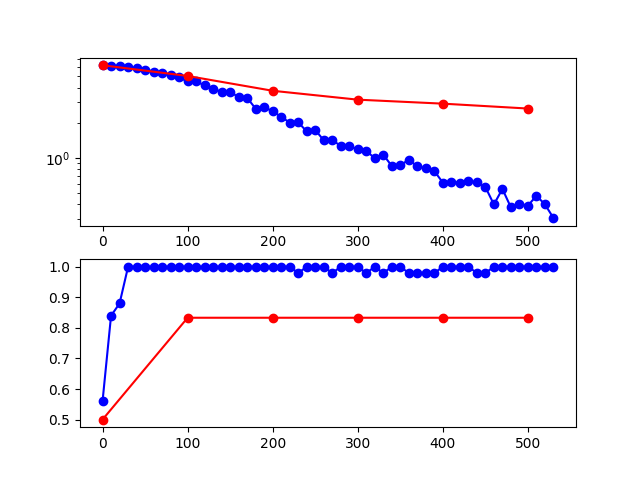

KeyboardInterrupt: 

In [13]:
learningRate = 1e-4

slim.losses.softmax_cross_entropy(net, labelsPh)
total_loss = slim.losses.get_total_loss()
tf.summary.scalar('loss', total_loss)

correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(labelsPh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

trainOp = tf.train.AdamOptimizer(learningRate).minimize(total_loss)
sess.run(tf.global_variables_initializer())
progressFig = plt.figure()
def evalTrainAccuracy(step, feedDict):
    feedDict[isTrainingPh] = False
    v = sess.run([total_loss, accuracy], feedDict)
    evalTrainAccuracy.x.append(step)
    evalTrainAccuracy.entropy.append(v[0])
    evalTrainAccuracy.accuracy.append(v[1])
    ax = plt.subplot(211)
    if evalTrainAccuracy.entropyLine:
        evalTrainAccuracy.entropyLine.set_xdata(evalTrainAccuracy.x)
        evalTrainAccuracy.entropyLine.set_ydata(evalTrainAccuracy.entropy)
    else:
        evalTrainAccuracy.entropyLine, = plt.semilogy(evalTrainAccuracy.x,
                     evalTrainAccuracy.entropy, 'bo-', label='Train')
    ax.relim()
    ax.autoscale_view()
    
    ax = plt.subplot(212)
    if evalTrainAccuracy.accuracyLine:
        evalTrainAccuracy.accuracyLine.set_xdata(evalTrainAccuracy.x)
        evalTrainAccuracy.accuracyLine.set_ydata(evalTrainAccuracy.accuracy)
    else:
        evalTrainAccuracy.accuracyLine, = plt.plot(evalTrainAccuracy.x,
                 evalTrainAccuracy.accuracy, 'bo-', label='Train')
    ax.relim()
    ax.autoscale_view()
    progressFig.canvas.draw()

evalTrainAccuracy.x = []
evalTrainAccuracy.entropy = []
evalTrainAccuracy.accuracy = []
evalTrainAccuracy.entropyLine = None
evalTrainAccuracy.accuracyLine = None

testImgs, testHist, testLabels = data.getTestData()
def evalTestAccuracy(step):
    feedDict = {
        imagesPh: testImgs,
        histPh: testHist,
        labelsPh: testLabels,
        isTrainingPh: False
    }
    v = sess.run([total_loss, accuracy], feedDict)
    evalTestAccuracy.x.append(step)
    evalTestAccuracy.entropy.append(v[0])
    evalTestAccuracy.accuracy.append(v[1])
    ax = plt.subplot(211)
    if evalTestAccuracy.entropyLine:
        evalTestAccuracy.entropyLine.set_xdata(evalTestAccuracy.x)
        evalTestAccuracy.entropyLine.set_ydata(evalTestAccuracy.entropy)
    else:
        evalTestAccuracy.entropyLine, = plt.semilogy(evalTestAccuracy.x,
                     evalTestAccuracy.entropy, 'ro-', label='Test')
    ax.relim()
    ax.autoscale_view()
    
    ax = plt.subplot(212)
    if evalTestAccuracy.accuracyLine:
        evalTestAccuracy.accuracyLine.set_xdata(evalTestAccuracy.x)
        evalTestAccuracy.accuracyLine.set_ydata(evalTestAccuracy.accuracy)
    else:
        evalTestAccuracy.accuracyLine, = plt.plot(evalTestAccuracy.x,
                 evalTestAccuracy.accuracy, 'ro-', label='Test')
    ax.relim()
    ax.autoscale_view()
    progressFig.canvas.draw()
evalTestAccuracy.x = []
evalTestAccuracy.entropy = []
evalTestAccuracy.accuracy = []
evalTestAccuracy.entropyLine = None
evalTestAccuracy.accuracyLine = None


trainStep = 0
for i in range(1001):
    imgs, hist, labels = data.getTrainBatch(50)
    trainFeedDict = {
        imagesPh: imgs,
        histPh: hist,
        labelsPh: labels,
        isTrainingPh: True
    }
    
    trainOp.run(feed_dict=trainFeedDict)
    
    if i % 10 == 0:
        evalTrainAccuracy(trainStep, trainFeedDict)
    
    if i % 100 == 0:
        evalTestAccuracy(trainStep)
    trainStep += 1

